In [1]:
from fastai.vision.all import *
import segmentation_models_pytorch as smp
from PIL import Image

In [2]:
dataroot_dir = Path('dataset/labeled_data')

In [3]:
dataroot_dir.ls()

(#3) [Path('dataset/labeled_data/images'),Path('dataset/labeled_data/.ipynb_checkpoints'),Path('dataset/labeled_data/labels')]

In [4]:
images = get_image_files(dataroot_dir/'images')
images

(#50) [Path('dataset/labeled_data/images/0031.png'),Path('dataset/labeled_data/images/0019.png'),Path('dataset/labeled_data/images/0042.png'),Path('dataset/labeled_data/images/0025.png'),Path('dataset/labeled_data/images/0030.png'),Path('dataset/labeled_data/images/0014.png'),Path('dataset/labeled_data/images/0006.png'),Path('dataset/labeled_data/images/0050.png'),Path('dataset/labeled_data/images/0001.png'),Path('dataset/labeled_data/images/0003.png'),Path('dataset/labeled_data/images/0008.png'),Path('dataset/labeled_data/images/0022.png'),Path('dataset/labeled_data/images/0012.png'),Path('dataset/labeled_data/images/0033.png'),Path('dataset/labeled_data/images/0046.png'),Path('dataset/labeled_data/images/0041.png'),Path('dataset/labeled_data/images/0005.png'),Path('dataset/labeled_data/images/0020.png'),Path('dataset/labeled_data/images/0047.png'),Path('dataset/labeled_data/images/0015.png')...]

In [5]:
im = images[0]; im

Path('dataset/labeled_data/images/0031.png')

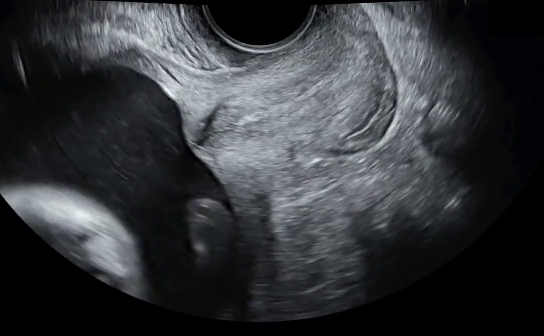

In [6]:
PILImage.create(im)

In [7]:
labels = get_image_files(dataroot_dir/'labels')
labels

(#50) [Path('dataset/labeled_data/labels/0031.png'),Path('dataset/labeled_data/labels/0019.png'),Path('dataset/labeled_data/labels/0042.png'),Path('dataset/labeled_data/labels/0025.png'),Path('dataset/labeled_data/labels/0030.png'),Path('dataset/labeled_data/labels/0014.png'),Path('dataset/labeled_data/labels/0006.png'),Path('dataset/labeled_data/labels/0050.png'),Path('dataset/labeled_data/labels/0001.png'),Path('dataset/labeled_data/labels/0003.png'),Path('dataset/labeled_data/labels/0008.png'),Path('dataset/labeled_data/labels/0022.png'),Path('dataset/labeled_data/labels/0012.png'),Path('dataset/labeled_data/labels/0033.png'),Path('dataset/labeled_data/labels/0046.png'),Path('dataset/labeled_data/labels/0041.png'),Path('dataset/labeled_data/labels/0005.png'),Path('dataset/labeled_data/labels/0020.png'),Path('dataset/labeled_data/labels/0047.png'),Path('dataset/labeled_data/labels/0015.png')...]

In [8]:
lbl = labels[0]; lbl

Path('dataset/labeled_data/labels/0031.png')

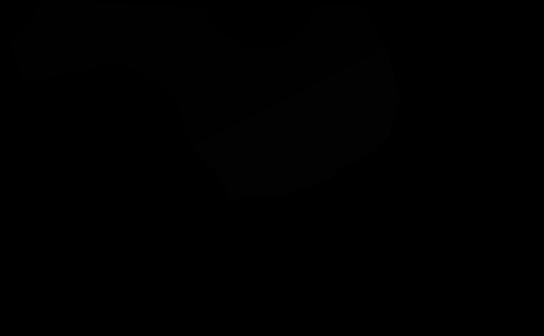

In [9]:
msk = PILMask.create(lbl);msk

 # DataLoaders -> DataLoader(TrainingSet), DataLoader(ValidationSet) - Dataset - x, y - Datablock

In [10]:
np.unique(msk)

array([0, 1, 2], dtype=uint8)

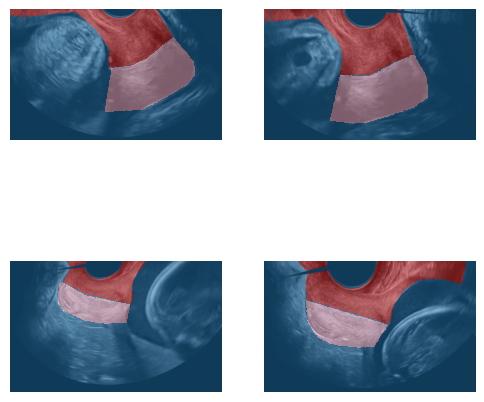

In [11]:
cervical_classes =['background','anterior', 'posterior']

cervcal_datablocks = (ImageBlock, MaskBlock(codes=cervical_classes))
def get_y(x): return(str(x).replace('images', 'labels'))

datablock = DataBlock(
    blocks= cervcal_datablocks,
    get_items=get_image_files,
    get_y = get_y,
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])
dls = datablock.dataloaders(dataroot_dir/'images', bs=4)
dls.show_batch()

In [12]:
xb, yb = dls.one_batch()

In [13]:
xb.shape, yb.shape

(torch.Size([4, 3, 336, 544]), torch.Size([4, 336, 544]))

In [14]:
yb.unique()

TensorMask([0, 1, 2], device='cuda:0')

In [15]:
len(dls.train_ds)

40

In [16]:
len(dls.valid_ds)

10

In [17]:
num_classes=3

model = smp.DeepLabV3Plus(
    encoder_name='efficientnet-b5',
    encoder_weights='imagenet',
    in_channels=3,
    classes=num_classes,
    activation=None
)


In [18]:
learn = Learner(dls, model, loss_func=FocalLossFlat(axis=1), metrics=[foreground_acc, DiceMulti(axis=1)],opt_func=ranger).to_fp16()

SuggestedLRs(valley=0.0010000000474974513)

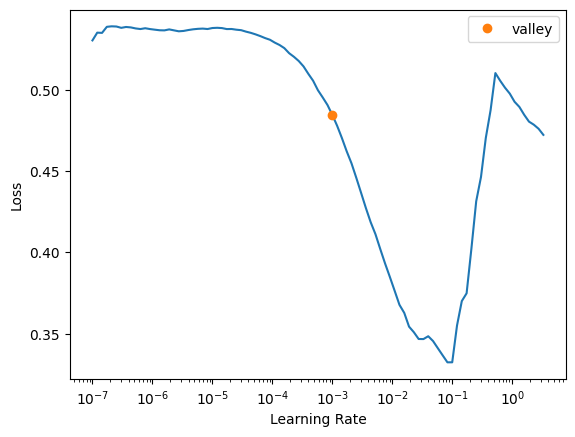

In [19]:
learn.lr_find()

In [20]:
learn.fit_one_cycle(50, 1e-3)

epoch,train_loss,valid_loss,foreground_acc,dice_multi,time
0,0.535825,0.495388,0.340124,0.174141,00:04
1,0.525851,0.484782,0.314735,0.286269,00:04
2,0.500574,0.446634,0.355966,0.419685,00:03
3,0.465238,0.384579,0.613697,0.546081,00:03
4,0.417835,0.300748,0.670430,0.649318,00:04
5,0.359505,0.231155,0.713823,0.731181,00:04
6,0.303192,0.163675,0.825339,0.806007,00:04
7,0.253506,0.115245,0.824821,0.835044,00:04
8,0.211784,0.082664,0.819238,0.856671,00:04
9,0.179529,0.075706,0.850283,0.856948,00:04


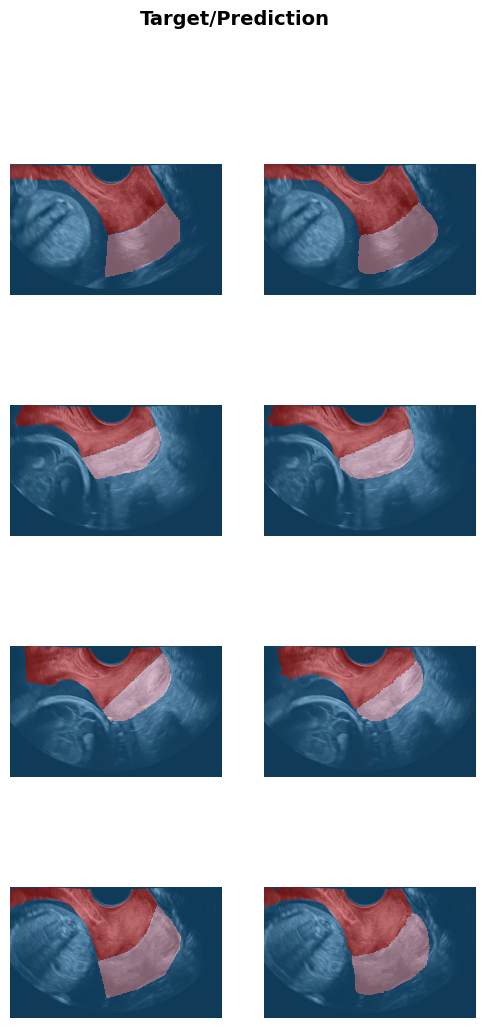

In [21]:
learn.show_results(max_n=4, figsize=(6,12))

In [22]:
learn.unfreeze()
learn.fit_one_cycle(50, slice(1e-3/400, 1e-3/4))

epoch,train_loss,valid_loss,foreground_acc,dice_multi,time
0,0.013569,0.016710,0.937785,0.957996,00:04
1,0.013412,0.016623,0.938800,0.958217,00:04
2,0.013711,0.016558,0.938895,0.958414,00:04
3,0.013781,0.016683,0.936556,0.957860,00:04
4,0.013853,0.016429,0.937876,0.958737,00:03
5,0.013687,0.016690,0.935896,0.958409,00:03
6,0.013437,0.016479,0.938612,0.957808,00:04
7,0.013610,0.017487,0.930025,0.955011,00:04
8,0.013574,0.016879,0.937878,0.957430,00:04
9,0.013557,0.018568,0.921096,0.953790,00:04


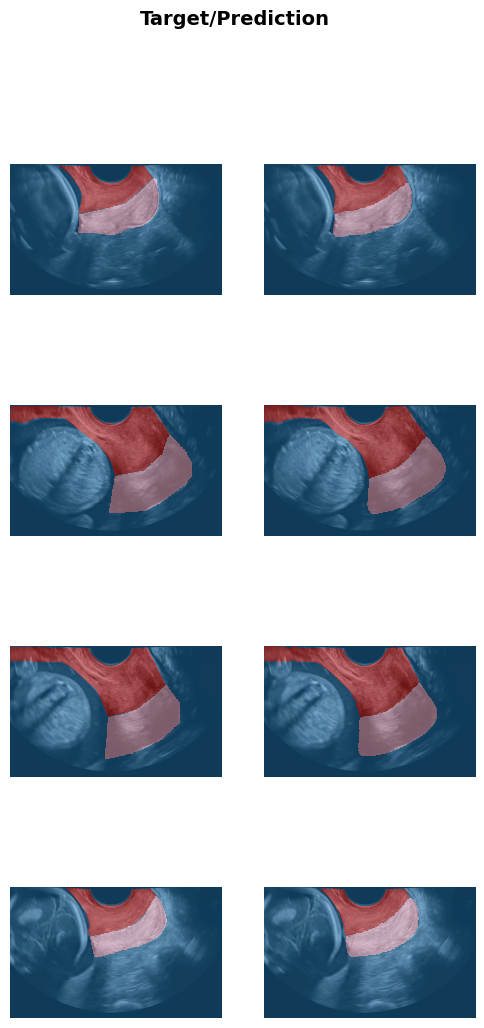

In [23]:
learn.show_results(max_n=4, figsize=(6,12))

In [24]:
learn.export('cervical_baseline_model_v1.pkl')  # Save the trained model

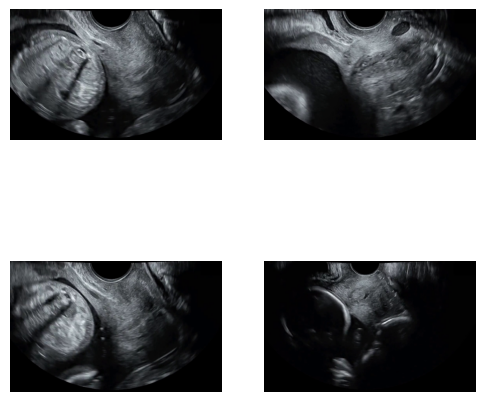

In [25]:
dl = learn.dls.test_dl(
    (Path('dataset/unlabeled_data/images')).ls()[:32]
)
dl.show_batch()

In [26]:
preds = learn.get_preds(dl=dl)

/usr/local/lib/python3.10/dist-packages/fastai/metrics.py:375: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)


In [27]:
preds[0].shape

torch.Size([32, 3, 336, 544])

In [28]:
preds[0][0].shape

torch.Size([3, 336, 544])

In [29]:
pred = preds[0][0].argmax(dim=0)

In [30]:
pred.shape

torch.Size([336, 544])

In [31]:
pred.unique()

tensor([0, 1, 2])

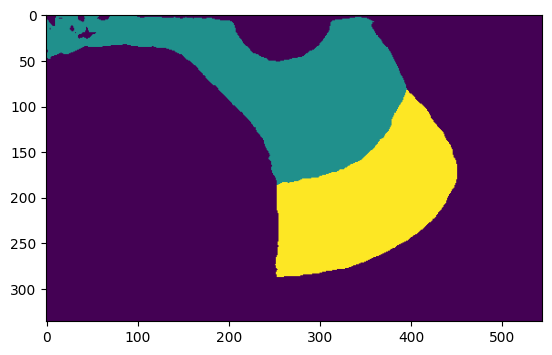

In [32]:
plt.imshow(pred);

In [33]:
def run_inference(input_folder, model_path, output_folder, batch_size=32):
    """
    Runs inference on images using a trained FastAI segmentation model 
    and saves class-encoded masks with the same filenames as the original images.

    Args:
        input_folder (str or Path): Path to the folder containing images.
        model_path (str or Path): Path to the trained .pkl model file.
        output_folder (str or Path): Path to save the generated masks.
        batch_size (int): Number of images to process per batch (default: 32).
    """
    input_folder = Path(input_folder)
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)  # Ensure the output folder exists

    # Load trained model
    learn = load_learner(model_path)

    # Get all image files from input folder
    image_files = input_folder.ls()

    # Process images in batches
    for i in range(0, len(image_files), batch_size):
        batch_files = image_files[i:i+batch_size]

        # Create test dataloader
        dl = learn.dls.test_dl(batch_files)

        # Get predictions
        preds, _ = learn.get_preds(dl=dl)

        # Save each predicted mask with the same filename as the original image
        for img_file, pred in zip(batch_files, preds):
            pred_mask = pred.argmax(0).cpu().numpy()  # Convert to class indices
            
            # Save mask using the same filename as input image
            mask_path = output_folder / f"{img_file.stem}.png"
            im = Image.fromarray(pred_mask.astype(np.uint8))  # Ensure 8-bit grayscale
            im.save(mask_path)

            print(f"Saved: {mask_path}")

    print("Inference completed. Masks saved in:", output_folder)

In [34]:
run_inference(
    input_folder="dataset/unlabeled_data/images",
    model_path="cervical_baseline_model_v1.pkl",
    output_folder="dataset/unlabeled_data/labels"
)

Saved: dataset/unlabeled_data/labels/0073.png
Saved: dataset/unlabeled_data/labels/0214.png
Saved: dataset/unlabeled_data/labels/0091.png
Saved: dataset/unlabeled_data/labels/0170.png
Saved: dataset/unlabeled_data/labels/0378.png
Saved: dataset/unlabeled_data/labels/0342.png
Saved: dataset/unlabeled_data/labels/0441.png
Saved: dataset/unlabeled_data/labels/0135.png
Saved: dataset/unlabeled_data/labels/0436.png
Saved: dataset/unlabeled_data/labels/0368.png
Saved: dataset/unlabeled_data/labels/0241.png
Saved: dataset/unlabeled_data/labels/0108.png
Saved: dataset/unlabeled_data/labels/0178.png
Saved: dataset/unlabeled_data/labels/0434.png
Saved: dataset/unlabeled_data/labels/0229.png
Saved: dataset/unlabeled_data/labels/0149.png
Saved: dataset/unlabeled_data/labels/0031.png
Saved: dataset/unlabeled_data/labels/0302.png
Saved: dataset/unlabeled_data/labels/0331.png
Saved: dataset/unlabeled_data/labels/0251.png
Saved: dataset/unlabeled_data/labels/0019.png
Saved: dataset/unlabeled_data/labe

Saved: dataset/unlabeled_data/labels/0442.png
Saved: dataset/unlabeled_data/labels/0095.png
Saved: dataset/unlabeled_data/labels/0408.png
Saved: dataset/unlabeled_data/labels/0025.png
Saved: dataset/unlabeled_data/labels/0069.png
Saved: dataset/unlabeled_data/labels/0030.png
Saved: dataset/unlabeled_data/labels/0413.png
Saved: dataset/unlabeled_data/labels/0094.png
Saved: dataset/unlabeled_data/labels/0351.png
Saved: dataset/unlabeled_data/labels/0070.png
Saved: dataset/unlabeled_data/labels/0195.png
Saved: dataset/unlabeled_data/labels/0234.png
Saved: dataset/unlabeled_data/labels/0370.png
Saved: dataset/unlabeled_data/labels/0181.png
Saved: dataset/unlabeled_data/labels/0183.png
Saved: dataset/unlabeled_data/labels/0243.png
Saved: dataset/unlabeled_data/labels/0014.png
Saved: dataset/unlabeled_data/labels/0078.png
Saved: dataset/unlabeled_data/labels/0006.png
Saved: dataset/unlabeled_data/labels/0233.png
Saved: dataset/unlabeled_data/labels/0371.png
Saved: dataset/unlabeled_data/labe

Saved: dataset/unlabeled_data/labels/0248.png
Saved: dataset/unlabeled_data/labels/0328.png
Saved: dataset/unlabeled_data/labels/0159.png
Saved: dataset/unlabeled_data/labels/0422.png
Saved: dataset/unlabeled_data/labels/0156.png
Saved: dataset/unlabeled_data/labels/0056.png
Saved: dataset/unlabeled_data/labels/0334.png
Saved: dataset/unlabeled_data/labels/0317.png
Saved: dataset/unlabeled_data/labels/0124.png
Saved: dataset/unlabeled_data/labels/0226.png
Saved: dataset/unlabeled_data/labels/0381.png
Saved: dataset/unlabeled_data/labels/0412.png
Saved: dataset/unlabeled_data/labels/0224.png
Saved: dataset/unlabeled_data/labels/0077.png
Saved: dataset/unlabeled_data/labels/0326.png
Saved: dataset/unlabeled_data/labels/0397.png
Saved: dataset/unlabeled_data/labels/0346.png
Saved: dataset/unlabeled_data/labels/0419.png
Saved: dataset/unlabeled_data/labels/0372.png
Saved: dataset/unlabeled_data/labels/0126.png
Saved: dataset/unlabeled_data/labels/0365.png
Saved: dataset/unlabeled_data/labe

Saved: dataset/unlabeled_data/labels/0123.png
Saved: dataset/unlabeled_data/labels/0396.png
Saved: dataset/unlabeled_data/labels/0276.png
Saved: dataset/unlabeled_data/labels/0188.png
Saved: dataset/unlabeled_data/labels/0360.png
Saved: dataset/unlabeled_data/labels/0279.png
Saved: dataset/unlabeled_data/labels/0162.png
Saved: dataset/unlabeled_data/labels/0414.png
Saved: dataset/unlabeled_data/labels/0230.png
Saved: dataset/unlabeled_data/labels/0293.png
Saved: dataset/unlabeled_data/labels/0444.png
Saved: dataset/unlabeled_data/labels/0012.png
Saved: dataset/unlabeled_data/labels/0231.png
Saved: dataset/unlabeled_data/labels/0257.png
Saved: dataset/unlabeled_data/labels/0202.png
Saved: dataset/unlabeled_data/labels/0307.png
Saved: dataset/unlabeled_data/labels/0421.png
Saved: dataset/unlabeled_data/labels/0177.png
Saved: dataset/unlabeled_data/labels/0300.png
Saved: dataset/unlabeled_data/labels/0053.png
Saved: dataset/unlabeled_data/labels/0064.png
Saved: dataset/unlabeled_data/labe

Saved: dataset/unlabeled_data/labels/0270.png
Saved: dataset/unlabeled_data/labels/0337.png
Saved: dataset/unlabeled_data/labels/0221.png
Saved: dataset/unlabeled_data/labels/0163.png
Saved: dataset/unlabeled_data/labels/0424.png
Saved: dataset/unlabeled_data/labels/0085.png
Saved: dataset/unlabeled_data/labels/0409.png
Saved: dataset/unlabeled_data/labels/0278.png
Saved: dataset/unlabeled_data/labels/0407.png
Saved: dataset/unlabeled_data/labels/0400.png
Saved: dataset/unlabeled_data/labels/0199.png
Saved: dataset/unlabeled_data/labels/0303.png
Saved: dataset/unlabeled_data/labels/0114.png
Saved: dataset/unlabeled_data/labels/0119.png
Saved: dataset/unlabeled_data/labels/0289.png
Saved: dataset/unlabeled_data/labels/0209.png
Saved: dataset/unlabeled_data/labels/0033.png
Saved: dataset/unlabeled_data/labels/0097.png
Saved: dataset/unlabeled_data/labels/0394.png
Saved: dataset/unlabeled_data/labels/0386.png
Saved: dataset/unlabeled_data/labels/0345.png
Saved: dataset/unlabeled_data/labe

Saved: dataset/unlabeled_data/labels/0092.png
Saved: dataset/unlabeled_data/labels/0423.png
Saved: dataset/unlabeled_data/labels/0074.png
Saved: dataset/unlabeled_data/labels/0207.png
Saved: dataset/unlabeled_data/labels/0353.png
Saved: dataset/unlabeled_data/labels/0113.png
Saved: dataset/unlabeled_data/labels/0196.png
Saved: dataset/unlabeled_data/labels/0272.png
Saved: dataset/unlabeled_data/labels/0146.png
Saved: dataset/unlabeled_data/labels/0052.png
Saved: dataset/unlabeled_data/labels/0223.png
Saved: dataset/unlabeled_data/labels/0054.png
Saved: dataset/unlabeled_data/labels/0220.png
Saved: dataset/unlabeled_data/labels/0364.png
Saved: dataset/unlabeled_data/labels/0308.png
Saved: dataset/unlabeled_data/labels/0286.png
Saved: dataset/unlabeled_data/labels/0109.png
Saved: dataset/unlabeled_data/labels/0102.png
Saved: dataset/unlabeled_data/labels/0182.png
Saved: dataset/unlabeled_data/labels/0348.png
Saved: dataset/unlabeled_data/labels/0072.png
Saved: dataset/unlabeled_data/labe

Saved: dataset/unlabeled_data/labels/0203.png
Saved: dataset/unlabeled_data/labels/0100.png
Saved: dataset/unlabeled_data/labels/0362.png
Saved: dataset/unlabeled_data/labels/0168.png
Saved: dataset/unlabeled_data/labels/0304.png
Saved: dataset/unlabeled_data/labels/0340.png
Saved: dataset/unlabeled_data/labels/0398.png
Saved: dataset/unlabeled_data/labels/0160.png
Saved: dataset/unlabeled_data/labels/0005.png
Saved: dataset/unlabeled_data/labels/0244.png
Saved: dataset/unlabeled_data/labels/0212.png
Saved: dataset/unlabeled_data/labels/0335.png
Saved: dataset/unlabeled_data/labels/0142.png
Saved: dataset/unlabeled_data/labels/0020.png
Saved: dataset/unlabeled_data/labels/0266.png
Saved: dataset/unlabeled_data/labels/0292.png
Saved: dataset/unlabeled_data/labels/0047.png
Saved: dataset/unlabeled_data/labels/0101.png
Saved: dataset/unlabeled_data/labels/0153.png
Saved: dataset/unlabeled_data/labels/0440.png
Saved: dataset/unlabeled_data/labels/0330.png
Saved: dataset/unlabeled_data/labe

Saved: dataset/unlabeled_data/labels/0200.png
Saved: dataset/unlabeled_data/labels/0194.png
Saved: dataset/unlabeled_data/labels/0112.png
Saved: dataset/unlabeled_data/labels/0418.png
Saved: dataset/unlabeled_data/labels/0015.png
Saved: dataset/unlabeled_data/labels/0361.png
Saved: dataset/unlabeled_data/labels/0192.png
Saved: dataset/unlabeled_data/labels/0287.png
Saved: dataset/unlabeled_data/labels/0375.png
Saved: dataset/unlabeled_data/labels/0428.png
Saved: dataset/unlabeled_data/labels/0179.png
Saved: dataset/unlabeled_data/labels/0310.png
Saved: dataset/unlabeled_data/labels/0080.png
Saved: dataset/unlabeled_data/labels/0249.png
Saved: dataset/unlabeled_data/labels/0155.png
Saved: dataset/unlabeled_data/labels/0132.png
Saved: dataset/unlabeled_data/labels/0032.png
Saved: dataset/unlabeled_data/labels/0379.png
Saved: dataset/unlabeled_data/labels/0158.png
Saved: dataset/unlabeled_data/labels/0010.png
Saved: dataset/unlabeled_data/labels/0088.png
Saved: dataset/unlabeled_data/labe

Saved: dataset/unlabeled_data/labels/0191.png
Saved: dataset/unlabeled_data/labels/0043.png
Saved: dataset/unlabeled_data/labels/0007.png
Saved: dataset/unlabeled_data/labels/0004.png
Saved: dataset/unlabeled_data/labels/0323.png
Saved: dataset/unlabeled_data/labels/0288.png
Saved: dataset/unlabeled_data/labels/0339.png
Saved: dataset/unlabeled_data/labels/0110.png
Saved: dataset/unlabeled_data/labels/0120.png
Saved: dataset/unlabeled_data/labels/0151.png
Saved: dataset/unlabeled_data/labels/0377.png
Saved: dataset/unlabeled_data/labels/0415.png
Saved: dataset/unlabeled_data/labels/0106.png
Saved: dataset/unlabeled_data/labels/0175.png
Saved: dataset/unlabeled_data/labels/0166.png
Saved: dataset/unlabeled_data/labels/0449.png
Saved: dataset/unlabeled_data/labels/0393.png
Saved: dataset/unlabeled_data/labels/0333.png
Saved: dataset/unlabeled_data/labels/0026.png
Saved: dataset/unlabeled_data/labels/0410.png
Saved: dataset/unlabeled_data/labels/0306.png
Saved: dataset/unlabeled_data/labe

Saved: dataset/unlabeled_data/labels/0150.png
Saved: dataset/unlabeled_data/labels/0076.png
Saved: dataset/unlabeled_data/labels/0037.png
Saved: dataset/unlabeled_data/labels/0391.png
Saved: dataset/unlabeled_data/labels/0227.png
Saved: dataset/unlabeled_data/labels/0305.png
Saved: dataset/unlabeled_data/labels/0264.png
Saved: dataset/unlabeled_data/labels/0190.png
Saved: dataset/unlabeled_data/labels/0172.png
Saved: dataset/unlabeled_data/labels/0165.png
Saved: dataset/unlabeled_data/labels/0430.png
Saved: dataset/unlabeled_data/labels/0273.png
Saved: dataset/unlabeled_data/labels/0271.png
Saved: dataset/unlabeled_data/labels/0262.png
Saved: dataset/unlabeled_data/labels/0343.png
Saved: dataset/unlabeled_data/labels/0320.png
Saved: dataset/unlabeled_data/labels/0246.png
Saved: dataset/unlabeled_data/labels/0016.png
Saved: dataset/unlabeled_data/labels/0145.png
Saved: dataset/unlabeled_data/labels/0222.png
Saved: dataset/unlabeled_data/labels/0280.png
Saved: dataset/unlabeled_data/labe

Saved: dataset/unlabeled_data/labels/0425.png
Saved: dataset/unlabeled_data/labels/0036.png
Saved: dataset/unlabeled_data/labels/0193.png
Saved: dataset/unlabeled_data/labels/0129.png
Saved: dataset/unlabeled_data/labels/0341.png
Saved: dataset/unlabeled_data/labels/0045.png
Saved: dataset/unlabeled_data/labels/0402.png
Saved: dataset/unlabeled_data/labels/0367.png
Saved: dataset/unlabeled_data/labels/0002.png
Saved: dataset/unlabeled_data/labels/0044.png
Saved: dataset/unlabeled_data/labels/0082.png
Saved: dataset/unlabeled_data/labels/0261.png
Saved: dataset/unlabeled_data/labels/0392.png
Saved: dataset/unlabeled_data/labels/0017.png
Saved: dataset/unlabeled_data/labels/0133.png
Saved: dataset/unlabeled_data/labels/0027.png
Saved: dataset/unlabeled_data/labels/0060.png
Saved: dataset/unlabeled_data/labels/0384.png
Saved: dataset/unlabeled_data/labels/0448.png
Saved: dataset/unlabeled_data/labels/0235.png
Saved: dataset/unlabeled_data/labels/0173.png
Saved: dataset/unlabeled_data/labe

Saved: dataset/unlabeled_data/labels/0131.png
Saved: dataset/unlabeled_data/labels/0427.png
Saved: dataset/unlabeled_data/labels/0281.png
Saved: dataset/unlabeled_data/labels/0084.png
Saved: dataset/unlabeled_data/labels/0417.png
Saved: dataset/unlabeled_data/labels/0403.png
Saved: dataset/unlabeled_data/labels/0090.png
Saved: dataset/unlabeled_data/labels/0284.png
Saved: dataset/unlabeled_data/labels/0446.png
Saved: dataset/unlabeled_data/labels/0125.png
Saved: dataset/unlabeled_data/labels/0237.png
Saved: dataset/unlabeled_data/labels/0429.png
Saved: dataset/unlabeled_data/labels/0021.png
Saved: dataset/unlabeled_data/labels/0137.png
Saved: dataset/unlabeled_data/labels/0197.png
Saved: dataset/unlabeled_data/labels/0127.png
Saved: dataset/unlabeled_data/labels/0275.png
Saved: dataset/unlabeled_data/labels/0240.png
Saved: dataset/unlabeled_data/labels/0023.png
Saved: dataset/unlabeled_data/labels/0242.png
Saved: dataset/unlabeled_data/labels/0111.png
Saved: dataset/unlabeled_data/labe

Saved: dataset/unlabeled_data/labels/0385.png
Saved: dataset/unlabeled_data/labels/0121.png
Saved: dataset/unlabeled_data/labels/0405.png
Saved: dataset/unlabeled_data/labels/0130.png
Saved: dataset/unlabeled_data/labels/0435.png
Saved: dataset/unlabeled_data/labels/0009.png
Saved: dataset/unlabeled_data/labels/0040.png
Saved: dataset/unlabeled_data/labels/0161.png
Saved: dataset/unlabeled_data/labels/0039.png
Saved: dataset/unlabeled_data/labels/0116.png
Saved: dataset/unlabeled_data/labels/0176.png
Saved: dataset/unlabeled_data/labels/0366.png
Saved: dataset/unlabeled_data/labels/0117.png
Saved: dataset/unlabeled_data/labels/0218.png
Saved: dataset/unlabeled_data/labels/0198.png
Saved: dataset/unlabeled_data/labels/0411.png
Saved: dataset/unlabeled_data/labels/0374.png
Saved: dataset/unlabeled_data/labels/0355.png
Saved: dataset/unlabeled_data/labels/0245.png
Saved: dataset/unlabeled_data/labels/0211.png
Saved: dataset/unlabeled_data/labels/0034.png
Saved: dataset/unlabeled_data/labe

Saved: dataset/unlabeled_data/labels/0357.png
Saved: dataset/unlabeled_data/labels/0313.png
Saved: dataset/unlabeled_data/labels/0296.png
Saved: dataset/unlabeled_data/labels/0186.png
Saved: dataset/unlabeled_data/labels/0268.png
Saved: dataset/unlabeled_data/labels/0174.png
Saved: dataset/unlabeled_data/labels/0038.png
Saved: dataset/unlabeled_data/labels/0447.png
Saved: dataset/unlabeled_data/labels/0068.png
Saved: dataset/unlabeled_data/labels/0299.png
Saved: dataset/unlabeled_data/labels/0057.png
Saved: dataset/unlabeled_data/labels/0028.png
Saved: dataset/unlabeled_data/labels/0035.png
Saved: dataset/unlabeled_data/labels/0024.png
Saved: dataset/unlabeled_data/labels/0115.png
Saved: dataset/unlabeled_data/labels/0238.png
Saved: dataset/unlabeled_data/labels/0327.png
Saved: dataset/unlabeled_data/labels/0011.png
Saved: dataset/unlabeled_data/labels/0388.png
Saved: dataset/unlabeled_data/labels/0369.png
Saved: dataset/unlabeled_data/labels/0259.png
Saved: dataset/unlabeled_data/labe

Saved: dataset/unlabeled_data/labels/0347.png
Saved: dataset/unlabeled_data/labels/0187.png
Inference completed. Masks saved in: dataset/unlabeled_data/labels


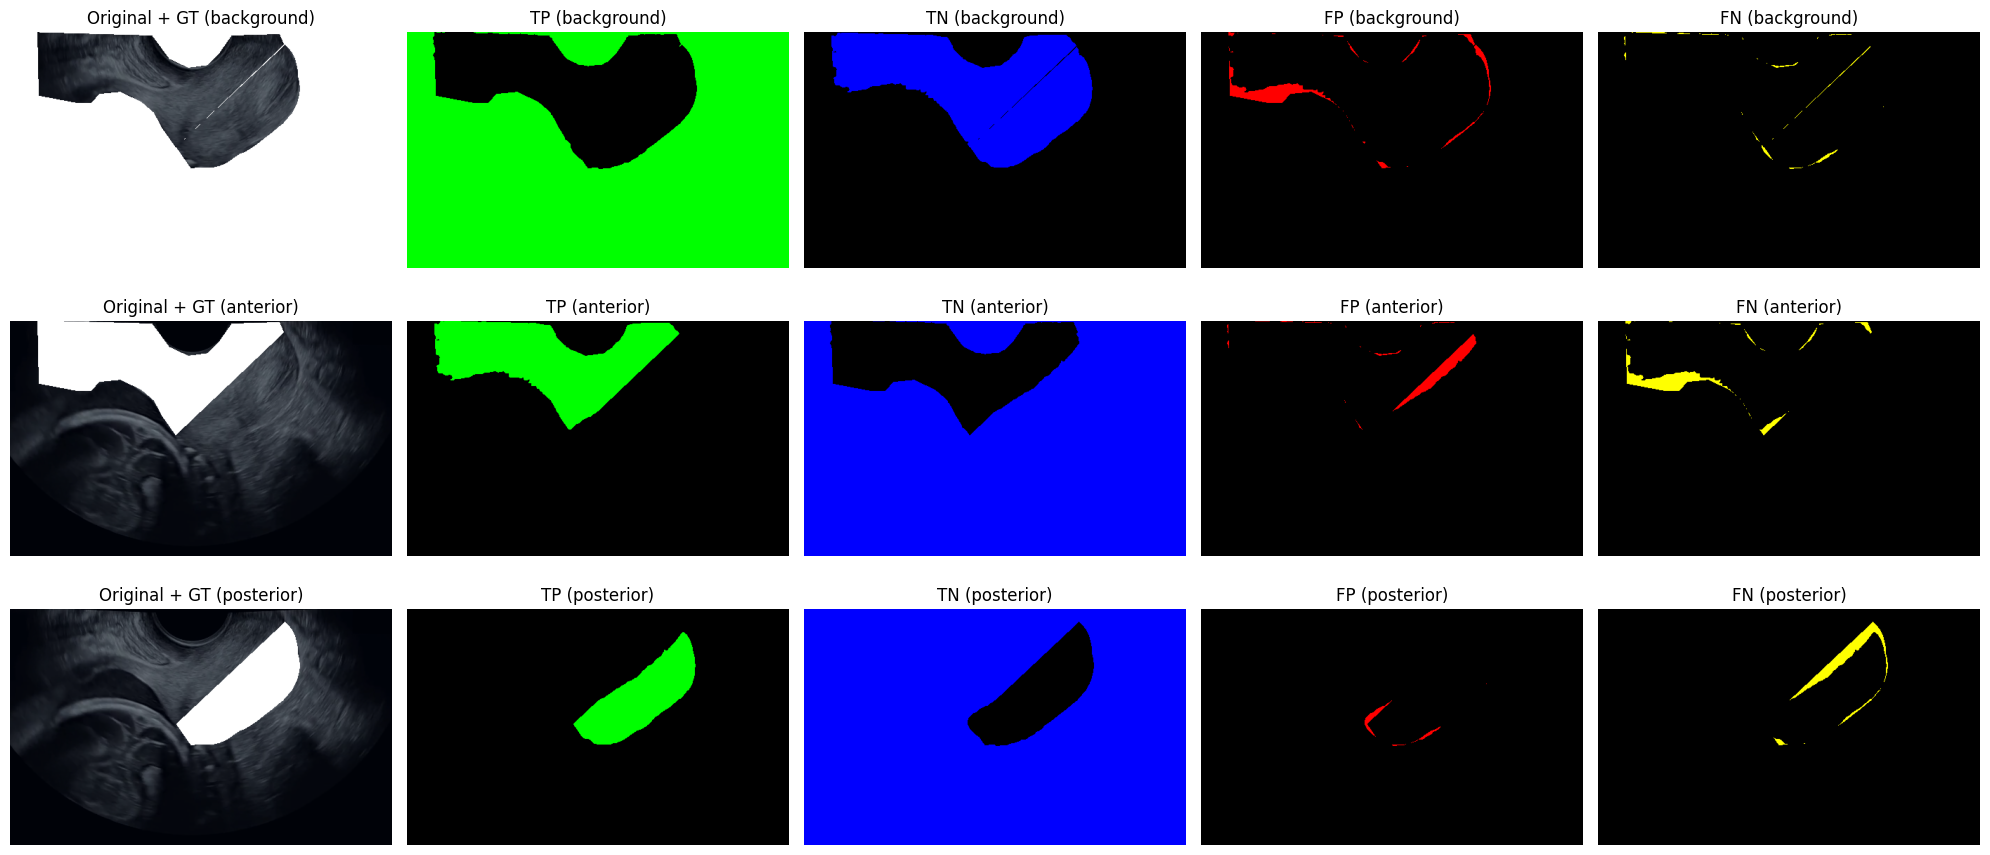

In [44]:
import random
import matplotlib.pyplot as plt
import torch
import numpy as np

# Define class names manually
cervical_classes = ['background', 'anterior', 'posterior']

def show_prediction_results(learn):
    """Displays a random validation sample with predicted vs ground truth masks.
    
    Rows:
    - Class Name (from `cervical_classes`)
    
    Columns:
    1. Original Image + Ground Truth Mask (Overlay)
    2. True Positive (TP) - Correctly predicted foreground (Green)
    3. True Negative (TN) - Correctly predicted background (Blue)
    4. False Positive (FP) - Wrongly predicted foreground (Red)
    5. False Negative (FN) - Wrongly predicted background (Yellow)
    
    Parameters:
    - learn: FastAI Learner (should have dls attached)
    """
    num_classes = len(cervical_classes)  # Get number of classes

    # Get a random validation batch
    dl = learn.dls.valid
    batch = dl.one_batch()

    # Pick one random image from the batch
    idx = random.randint(0, len(batch[0]) - 1)
    img, gt_mask = batch[0][idx], batch[1][idx]

    # Move to CPU for visualization
    img = img.cpu().permute(1, 2, 0).numpy()  # Convert to HWC format for plotting
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for display

    gt_mask = gt_mask.cpu().squeeze().numpy()  # Convert ground truth mask to 2D

    # Predict mask using the model
    with torch.no_grad():
        pred_mask = learn.model(batch[0][idx].unsqueeze(0).to(learn.dls.device))
        pred_mask = pred_mask.argmax(dim=1).cpu().squeeze().numpy()  # Convert to class labels

    # Define colors for TP, TN, FP, FN
    colors = {
        "TP": (0, 255, 0),   # Green
        "TN": (0, 0, 255),   # Blue
        "FP": (255, 0, 0),   # Red
        "FN": (255, 255, 0)  # Yellow
    }

    # Prepare figure with rows = classes and cols = 5 (Original + 4 Mask Comparisons)
    fig, axes = plt.subplots(num_classes, 5, figsize=(20, num_classes * 3))

    for class_idx in range(num_classes):
        class_name = cervical_classes[class_idx]  # Get class name

        # Compute TP, TN, FP, FN masks for this class
        tp_mask = (pred_mask == class_idx) & (gt_mask == class_idx)  # True Positive
        tn_mask = (pred_mask != class_idx) & (gt_mask != class_idx)  # True Negative
        fp_mask = (pred_mask == class_idx) & (gt_mask != class_idx)  # False Positive
        fn_mask = (pred_mask != class_idx) & (gt_mask == class_idx)  # False Negative

        # Convert binary masks to RGB
        def mask_to_rgb(mask, color):
            """Converts a binary mask to an RGB color mask."""
            rgb = np.zeros((*mask.shape, 3), dtype=np.uint8)
            rgb[mask] = color
            return rgb

        tp_rgb = mask_to_rgb(tp_mask, colors["TP"])
        tn_rgb = mask_to_rgb(tn_mask, colors["TN"])
        fp_rgb = mask_to_rgb(fp_mask, colors["FP"])
        fn_rgb = mask_to_rgb(fn_mask, colors["FN"])

        # Overlay Ground Truth Mask on the Original Image
        overlay = img.copy()
        mask_overlay = np.zeros_like(img)
        mask_overlay[gt_mask == class_idx] = [255, 255, 255]  # White mask overlay
        overlay = np.clip(overlay * 0.5 + mask_overlay * 0.5, 0, 1)  # Blend with original image

        # Plot images for the current class
        axes[class_idx, 0].imshow(overlay)
        axes[class_idx, 0].set_title(f"Original + GT ({class_name})")

        axes[class_idx, 1].imshow(tp_rgb)
        axes[class_idx, 1].set_title(f"TP ({class_name})")

        axes[class_idx, 2].imshow(tn_rgb)
        axes[class_idx, 2].set_title(f"TN ({class_name})")

        axes[class_idx, 3].imshow(fp_rgb)
        axes[class_idx, 3].set_title(f"FP ({class_name})")

        axes[class_idx, 4].imshow(fn_rgb)
        axes[class_idx, 4].set_title(f"FN ({class_name})")

        for ax in axes[class_idx, :]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# Run the function
show_prediction_results(learn)